# Spatial Distribution of Childcare Spots by Municipality in the Netherlands

**Author:** Jiale Zhang, CEMFI

**Date:** March 31, 2023 

**Course:** Urban Economics

**Professor:** Daniel Arribas-Bel

# Introduction

The issue of gender inequality has been a topic of discussion for many years, with various studies and policies aimed at addressing the imbalance. One such study, "Do Family Policies Reduce Gender Inequality? Evidence from 60 Years of Policy Experimentation" (Kleven et al., 2020), explores the impact of family policies on gender inequality. The authors of the study utilize maps to illustrate their argument, specifically maps showcasing child care availability by municipality. The child care index used in the study is created by dividing the total number of available childcare spots in a municipality by the total number of eligible children in that county. 

In this project, I will create a similar map using publicly available data on child care centers within the Netherlands. Although more detailed data on school-aged children by municipality or population size is not available, the absolute number of available childcare spots will be utilized to generate the map.

# Data

## 1. Childcare centers in the Netherlands

The [data](https://data.overheid.nl/dataset/gegevens-kinderopvanglocaties-lrk#panel-resources) on childcare centers in the Netherlands can be found here. It is a weekly updated data set recording all publicly registered childcare units in the Netherlands. Each entry identifies one childcare center, with its address (specified to zip code level) and the number of spots it can host.

## 2. Map of the Netherlands 

I downloaded the gpkg file of [administrative boundaries](https://www.pdok.nl/downloads/-/article/bestuurlijke-grenzen#6513c4f4cd0bae75f6b48a930937eb1f) in the Netherlands from the Dutch government website PDOK. 

# Codes

In [4]:
# Libraries
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt
import mapclassify as mc
import pandas as pd
import os
import csv

In [6]:
#Set working directory
os.chdir(os.getcwd())

In [7]:
# Prepare data sets

#import data for childcare centers and the netherlands
childcare = pd.read_csv('child_care_nl.csv', encoding = 'Windows-1252')
netherlands = gpd.read_file('netherlands.gpkg')

#change name to merge
childcare = childcare.rename(columns = {'municipality_code': 'code'} )

#Calculate number of spots per municipality
grouped_childcare = childcare.groupby('code') #group by municipality

spots_by_municipality = grouped_childcare["spots_available"].sum() #sum by municipality

spots_by_municipality.to_csv('spots_by_municipality.csv')

#get data again
spots_by_mul = pd.read_csv('spots_by_municipality.csv', encoding = 'Windows-1252')

In [8]:
#Merge

#change variable type to merge
spots_by_mul['code'] = spots_by_mul['code'].apply(lambda x: '{:04d}'.format(x))

#change variable type to merge 
spots_by_mul['code'] = spots_by_mul['code'].astype(object)

#spots_by_mul.head()

merge1 = pd.merge( netherlands, spots_by_mul, on = 'code', how = 'outer') #merge by municipality code 

merge1['spots_available'] = merge1['spots_available'].fillna(0) #fill missing values with 0

In [9]:
# Classify the municipalities into 7 categories based on the number of childcare centers using Jenks natural breaks, and fit it to the data
classifier = mc.FisherJenks(merge1['spots_available'], k=7)

# get the class break points
breaks = classifier.bins

merge1 = merge1.assign(
    classes = classifier.yb)

merge1.loc[merge1['classes'] == 0, 'classes'] = '0 - 1005'
merge1.loc[merge1['classes'] == 1, 'classes'] = '1005 - 2081'
merge1.loc[merge1['classes'] == 2, 'classes'] = '2081 - 3807'
merge1.loc[merge1['classes'] == 3, 'classes'] = '3807 - 6494'
merge1.loc[merge1['classes'] == 4, 'classes'] = '6494 - 11703'
merge1.loc[merge1['classes'] == 5, 'classes'] = '11703 - 27760'
merge1.loc[merge1['classes'] == 6, 'classes'] = '27760 - 35428'


# define the order of the categories
category_order = ['0 - 1005', '1005 - 2081', '2081 - 3807', '3807 - 6494', '6494 - 11703', '11703 - 27760', '27760 - 35428']

# convert the 'variable' column to a categorical variable with the specified order
merge1['classes'] = pd.Categorical(merge1['classes'], categories=category_order, ordered=True)

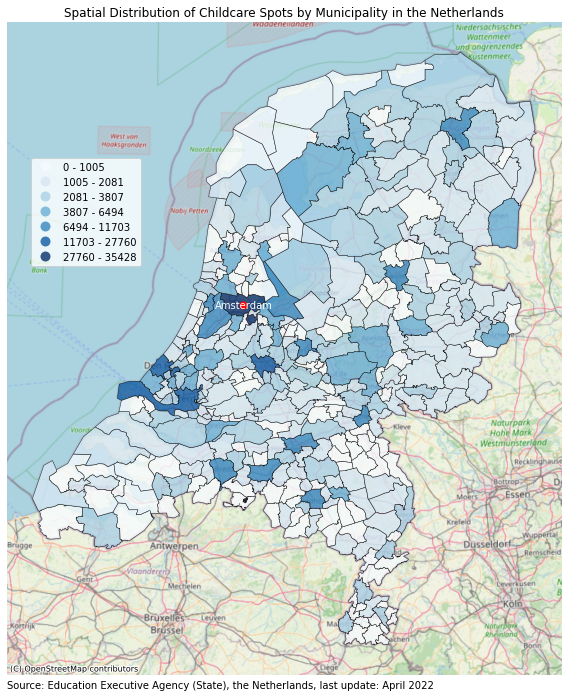

In [19]:
# Plot

#Plot the data with the class labels
fig, ax = plt.subplots(figsize = (12, 12))

merge1.plot(column='classes', cmap='Blues', linewidth=0.5, alpha=0.8, edgecolor='black', ax=ax, legend=True)

#Add base map with contextily
contextily.add_basemap(ax=ax, crs=merge1.crs.to_string(), source=contextily.providers.OpenStreetMap.Mapnik)


# Set the title and axis labels
ax.set_title("Spatial Distribution of Childcare Spots by Municipality in the Netherlands")

# Move the legend to the lower left corner
ax.get_legend().set_bbox_to_anchor((0.25, 0.8))

# Remove the axis lines, ticks, and labels, because I think they look ugly
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])

# Point out Amsterdam on the map
amsterdam = merge1[merge1['code'] == '0363']


# Add a red scatter point at the centroid of the municipality of interest
centroid = amsterdam.geometry.centroid
ax.scatter(x=centroid.x, y=centroid.y, color='red', s=50)

# Add a label with the name of the municipality of interest at the same location as the scatter point

ax.text(x= centroid.x + 500, y= centroid.y, s= 'Amsterdam', ha='center', va='center', color='white', fontsize=10)

#Source of the map
plt.text(0.385, -0.02, 'Source: Education Executive Agency (State), the Netherlands, last update: April 2022', ha='center', transform=ax.transAxes)

# Show the plot
plt.show()

# Conclusion

We can see from the map that there are more childcare spots in Amsterdam than in any other municipality. And it seems there is a spatial correlation between municipalities for the number of available childcare spots. As we can tell from the map, rarely are light shades directly attached to dark shades. Despite the correlation, we can also see that many childcare spots are centered around the northwest of the country, close to Amsterdam.

# References

[1] .Kleven, Henrik Jacobsen, Camille Landais, Johanna Posch, Andreas Steinhauer and Josef Zweimüller. “Do Family Policies Reduce Gender Inequality? Evidence from 60 Years of Policy Experimentation.” CEPR Discussion Paper Series (2020): n. pag.

[2] Administrative Boundaries Extract (History), the Netherlands. PDOK. Retrieved March 15, 2023, from https://www.pdok.nl/downloads/-/article/bestuurlijke-grenzen#6513c4f4cd0bae75f6b48a930937eb1f

[3] Details childcare locations LR. Overheid. Retrieved March 15, 2023, from https://data.overheid.nl/dataset/gegevens-kinderopvanglocaties-lrk#panel-resources